# Best fits analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.integrate import solve_ivp
from scipy.constants import c as c_light  # units of m/s
c_light_km = c_light / 1000 # units of km/s

# import libraries:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_figures = os.path.join(path_git, 'notebooks', 'figures')

#B1: lcdm biased
#B2: GILA biased

# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap

#Import standard libraries
import numpy as np
import time
import seaborn as sns
import pandas as pd
from itertools import product

from scipy.interpolate import interp1d
from scipy.integrate import simps as simps
from scipy.integrate import cumtrapz as cumtrapz
from scipy.integrate import simps, solve_ivp
from scipy.constants import c as c_light #meters/seconds

c_light_km = c_light/1000 #km/s

import getdist
getdist.chains.print_load_details = False

# import repo functions:
import sys, os
import os
import git
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_data = os.path.join(os.path.dirname(path_git), 'GILA-output', 'paper')
path_figures = os.path.join(path_git, 'notebooks', 'figures')

os.chdir(os.path.join(path_git, 'fr_mcmc', 'utils'))
from supernovae import aparent_magnitude_th, chi2_supernovae
from constants import OMEGA_R_0, LAMBDA, L, KAPPA

In [2]:
def F_H(H, params, model):     
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        FH = H**2 - beta * H**(2*r) * L_bar**(2*(r-1)) * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        FH = H**2 - beta * H**2                        * np.exp(-beta*(L_bar*H)**(2*s)) #\
                  #+ lamb * H**(2*p) * L**(2*(p-1))     * np.exp(lamb*(L*H)**(2*q))

    return FH


def F_H_prime(H, params, model):
    lamb, L, beta, L_bar, r, s = params # L and L_bar have to be in units of H0^{-1}
   
    if model == 'GILA':
        lamb = 0; p = 3; q = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s)) * (L_bar*H)**(2*(r-1)) * (-r + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1))     * (p  + q * lamb * (L*H)**(2*q))

    elif model == 'BETA':
        lamb = 0; p = 1; q = 2; r = 1
        aux = beta * np.exp(-beta*(L_bar*H)**(2*s))                        * (-1 + s * beta * (L_bar*H)**(2*s)) #+\
              #lamb * np.exp(lamb*(L*H)**(2*q))      * (L*H)**(2*(p-1)) * (p  + q * lamb * (L*H)**(2*q))

    FH_prime = 2 * H * (1 + aux) 
    return FH_prime


def get_odes(z, Hubble, params_ode, lcdm=False):
    '''
    Returns the system of ODEs for the given cosmological model.


    Parameters:
    -----------
    z : float
        Redshift value.
    variables : list
        List of values for the dynamical variables.
    physical_params : list
        List of model parameters, where the first n-1 elements are the model parameters,
        while the last one specifies the cosmological model. Mathematically, this information is contained in
        the function Gamma.
    model : str, optional
        Cosmological model that is being integrated. Defaults to 'LCDM'.

    Returns:
    -----------
    list
        Set of ODEs for the dynamical variables.
    '''    
    [LAMBDA, L, b, L_bar, H_0, r, s, model] = params_ode #Here L and L_bar are in units of H0^{-1}

    F_H0 = F_H(H_0, [LAMBDA, L, b, L_bar, r, s], model)

    omega_m_0 = F_H0 /(100**2) - OMEGA_R_0

    rho_m_0 = 100**2 * omega_m_0 / KAPPA
    rho_r_0 = 100**2 * OMEGA_R_0 / KAPPA
    
    rho_r = rho_r_0 * (1+z)**4
    rho_m = rho_m_0 * (1+z)**3
    rho_tot =  rho_r + rho_m 
    p_tot =  (1/3) * rho_r

    # To integrate in z
    s =  3 * KAPPA * (rho_tot + p_tot/c_light_km**2) / ((1+z)*F_H_prime(Hubble, [LAMBDA, L, b, L_bar, r, s], model))     
    #print(s)
    return s


def integrator_GILA(physical_params, model, num_z_points=int(10**5),
                initial_z=0, final_z=3,
                system_equations=get_odes, verbose=False,
                method='RK45', rtol=1e-11, atol=1e-16):
 
    t1 = time.time()
    #L_bar, b, H0 = physical_params
    L_bar, b, H0, r, s = physical_params
    
    #Cambiar si pasamos de logspace a linspace!
    zs_int = np.linspace(initial_z, final_z, num_z_points)
    
    #ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, model]
    ode_params = [LAMBDA, L/H0, b, L_bar/H0, H0, r, s, model]
    sol = solve_ivp(system_equations, (initial_z,final_z),
                    [H0], t_eval=zs_int, args = [ode_params],
                    rtol=rtol, atol=atol, method=method)
        

    assert len(sol.t)==num_z_points, 'Something is wrong with the integration!'
    assert np.all(zs_int==sol.t), 'Not all the values of z coincide with the ones that were required!'

    # Calculate the Hubble parameter
    zs_final = sol.t
    Hs_final = sol.y[0]

    t2 = time.time()

    if verbose == True:
        print('Duration: {} minutes and {} seconds'.format(int((t2-t1)/60),
                int((t2-t1) - 60*int((t2-t1)/60))))

    return zs_final, Hs_final

def E_2(zs, Omega_r, Omega_m, Omega_Lambda):
    return (1+zs)**4 * Omega_r + (1+zs)**3 * Omega_m + Omega_Lambda

In [3]:
#Fixed values
zs = np.linspace(0,10,10**5)
omega_r = 2.47e-5
L_bar = 0.90
r = 3.0
s = 5.0  

#Lcdm best fit
H_0_lcdm = 72.163
omega_m_lcdm = 0.163

##Beta best fit
#beta_beta = 0.7
#H_0_beta = 70

#GILA best fit
beta_gila = 3.724983
H_0_gila = 67.330641


#GILA model
#Exponents: r = 3, s = 5
#M abs: -19.499030 \pm 0.212081
#H0: 67.330641 \pm 5.168819
#$\beta$: 3.724983 \pm 1.626511

In [4]:
#Lcdm model
Omega_r_lcdm = omega_r/(H_0_lcdm/100)**2
Omega_m_lcdm = omega_m_lcdm / (H_0_lcdm/100)**2
Omega_Lambda_lcdm = 1 - Omega_r_lcdm - Omega_m_lcdm

Omega_r_lcdm_z = Omega_r_lcdm * (1+zs)**4 / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)
Omega_m_lcdm_z = Omega_m_lcdm * (1+zs)**3 / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)
Omega_Lambda_lcdm_z = Omega_Lambda_lcdm / E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm)

#Beta model
#omega_m_beta = F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/(100**2) - omega_r

#Omega_r_beta_B1 = omega_r/(H_0_beta/100)**2
#Omega_m_beta_B1 = omega_m_beta / (H_0_beta/100)**2
#Omega_Lambda_beta_B1 = 1- Omega_r_beta_B1 - Omega_m_beta_B1

#Omega_r_beta_B2 = omega_r / (F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/100**2)
#Omega_m_beta_B2 = omega_m_beta / (F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/100**2)

#physical_params = [L_bar, beta_beta, H_0_beta]
#_, Hs_beta = integrator(physical_params, num_z_points=int(1e5), initial_z=0, final_z=10,model='BETA')

#Omega_r_beta_B1_z = Omega_r_beta_B1 * (1+zs)**4 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
##Omega_m_beta_B1_z = Omega_m_beta_B1 * (1+zs)**3 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
#Omega_Lambda_beta_B1_z = Omega_Lambda_beta_B1 / E_2(zs, Omega_r_beta_B1, Omega_m_beta_B1, Omega_Lambda_beta_B1)
#Omega_r_beta_B2_z = Omega_r_beta_B2 * (1+zs)**4 / (F_H(Hs_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA'))
#Omega_m_beta_B2_z = Omega_m_beta_B2 * (1+zs)**3 / (F_H(Hs_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA')/F_H(H_0_beta, [0, 0, beta_beta, L_bar/H_0_beta], 'BETA'))

#GILA model
omega_m_gila = F_H(H_0_gila, [0, 1, beta_gila, L_bar/H_0_gila,r,s], 'GILA')/(100**2) - omega_r

Omega_r_gila_B1 = omega_r/(H_0_gila/100)**2
Omega_m_gila_B1 = omega_m_gila / (H_0_gila/100)**2
Omega_Lambda_gila_B1 = 1- Omega_r_gila_B1 - Omega_m_gila_B1

Omega_r_gila_B2 = omega_r / (F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA')/100**2)
Omega_m_gila_B2 = omega_m_gila / (F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA')/100**2)

physical_params = [L_bar, beta_gila, H_0_gila,r,s]
_, Hs_gila = integrator_GILA(physical_params, num_z_points=int(1e5), initial_z=0, final_z=10,model='GILA')

Omega_r_gila_B1_z = Omega_r_gila_B1 * (1+zs)**4 / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_m_gila_B1_z = Omega_m_gila_B1 * (1+zs)**3 / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_Lambda_gila_B1_z = Omega_Lambda_gila_B1   / E_2(zs, Omega_r_gila_B1, Omega_m_gila_B1, Omega_Lambda_gila_B1)
Omega_r_gila_B2_z = Omega_r_gila_B2 * (1+zs)**4 / (F_H(Hs_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA')/F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA'))
Omega_m_gila_B2_z = Omega_m_gila_B2 * (1+zs)**3 / (F_H(Hs_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA')/F_H(H_0_gila, [0, 0, beta_gila, L_bar/H_0_gila,r,s], 'GILA'))

print('LCDM: {}'.format(Omega_r_lcdm + Omega_m_lcdm + Omega_Lambda_lcdm))
#print('BETA_B1: {}'.format(Omega_r_beta_B1 + Omega_m_beta_B1 + Omega_Lambda_beta_B1))
print('GILA_B1: {}'.format(Omega_r_gila_B1 + Omega_m_gila_B1 + Omega_Lambda_gila_B1))
#print('BETA_B2: {}'.format(Omega_r_beta_B2 + Omega_m_beta_B2))
print('GILA_B2: {}'.format(Omega_r_gila_B2 + Omega_m_gila_B2))

#print(Omega_m_beta_B1, Omega_m_gila_B1)
#print(Omega_r_beta_B2, Omega_m_gila_B2)

LCDM: 0.9999999999999999
GILA_B1: 1.0
GILA_B2: 1.0


/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:43: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


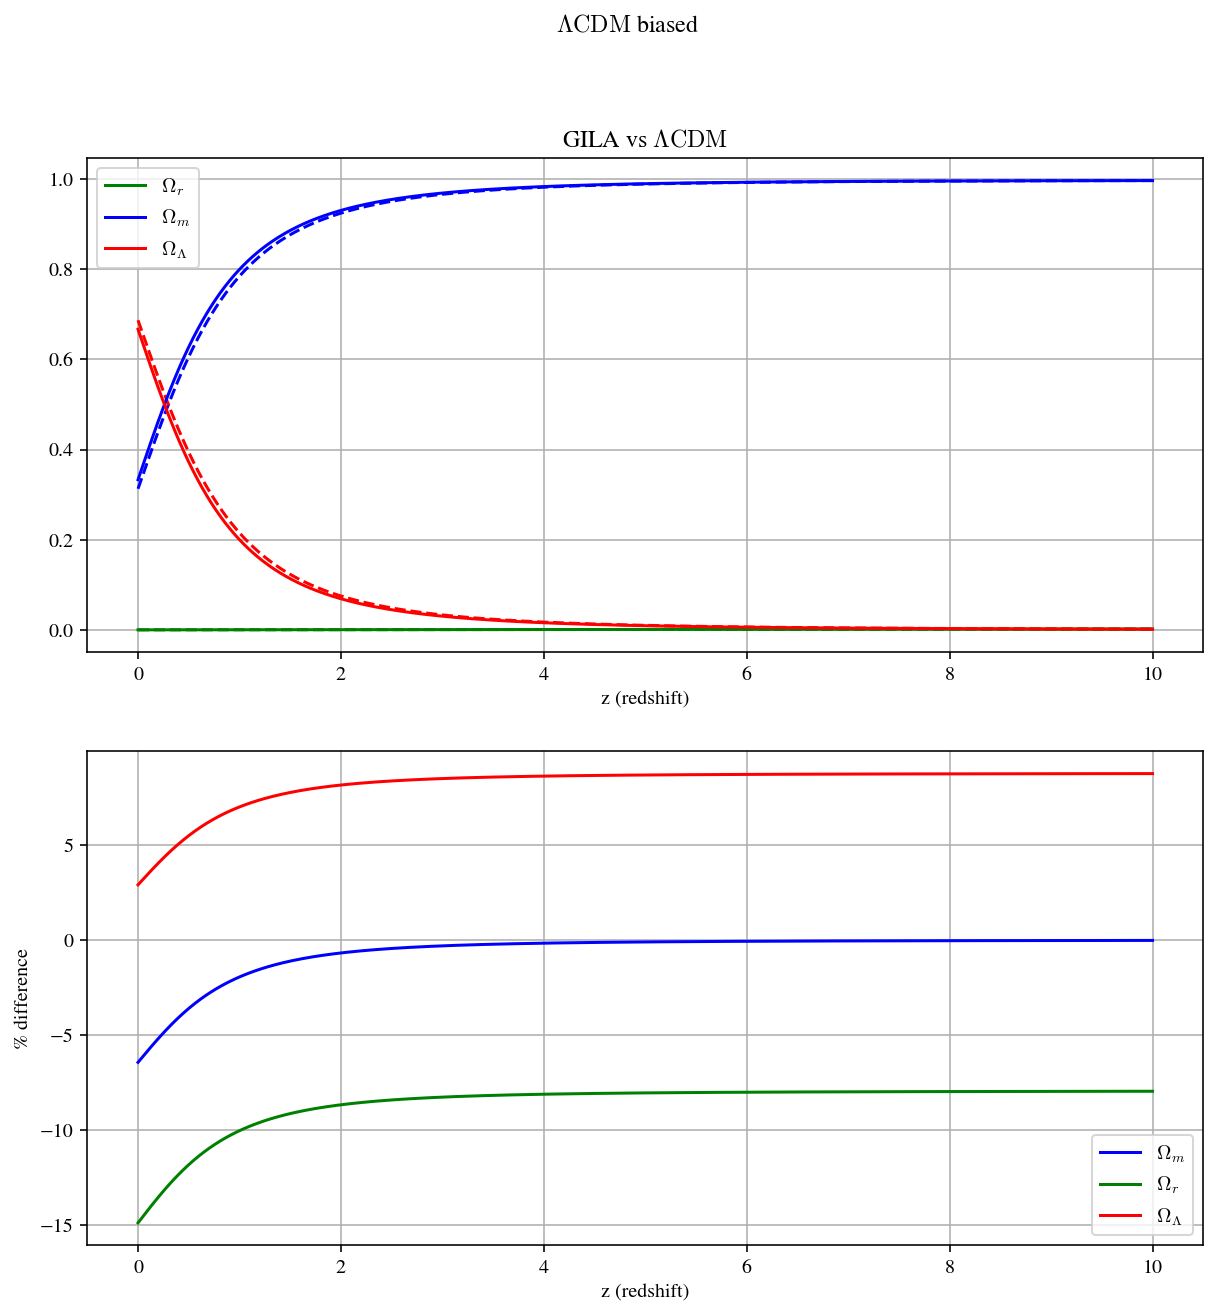

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle(r'$\rm{\Lambda CDM}$ biased')

#ax[0].set_title(r'BETA vs $\rm{\Lambda CDM}$')
#ax[0].grid()
#ax[0].plot(zs, Omega_r_lcdm_z, 'g--')
#ax[0].plot(zs, Omega_m_lcdm_z, 'b--')
#ax[0].plot(zs, Omega_Lambda_lcdm_z, 'r--')
#ax[0,0].plot(zs, Omega_r_beta_B1_z, 'g', label=r'$\Omega_r$')
#ax[0,0].plot(zs, Omega_m_beta_B1_z, 'b', label=r'$\Omega_m$')
#ax[0,0].plot(zs, Omega_Lambda_beta_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
#ax[0].set_xlabel('z (redshift)')
#ax[0].legend()

ax[0].set_title(r'GILA vs $\rm{\Lambda CDM}$')
ax[0].grid()
ax[0].plot(zs, Omega_r_lcdm_z, 'g--')
ax[0].plot(zs, Omega_m_lcdm_z, 'b--')
ax[0].plot(zs, Omega_Lambda_lcdm_z, 'r--')
ax[0].plot(zs, Omega_r_gila_B1_z, 'g', label=r'$\Omega_r$')
ax[0].plot(zs, Omega_m_gila_B1_z, 'b', label=r'$\Omega_m$')
ax[0].plot(zs, Omega_Lambda_gila_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
ax[0].set_xlabel('z (redshift)')
ax[0].legend()

#ax[1,0].grid()
#ax[1,0].plot(zs, 100*(1-Omega_r_beta_B1_z/Omega_r_lcdm_z), 'g', label=r'$\Omega_r$')
#ax[1,0].plot(zs, 100*(1-Omega_m_beta_B1_z/Omega_m_lcdm_z), 'b',label=r'$\Omega_m$')
#ax[1,0].plot(zs, 100*(1-Omega_Lambda_beta_B1_z/Omega_Lambda_lcdm_z), 'r', label=r'$\Omega_{{\Lambda}}$')
#ax[1,0].set_ylabel('% difference')
#ax[1,0].set_xlabel('z (redshift)')
#ax[1,0].legend()

ax[1].grid()
ax[1].plot(zs, 100*(1-Omega_m_gila_B1_z/Omega_m_lcdm_z), 'b',label=r'$\Omega_m$')
ax[1].plot(zs, 100*(1-Omega_r_gila_B1_z/Omega_r_lcdm_z), 'g', label=r'$\Omega_r$')
ax[1].plot(zs, 100*(1-Omega_Lambda_gila_B1_z/Omega_Lambda_lcdm_z), 'r', label=r'$\Omega_{{\Lambda}}$')
ax[1].set_ylabel('% difference')
ax[1].set_xlabel('z (redshift)')
ax[1].legend()

os.chdir(path_figures)
fig.savefig('Omegas_LCDM_biased_{}.pdf'.format(L_bar))

No handles with labels found to put in legend.
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
/home/matias/anaconda3/envs/fR-MCMC/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


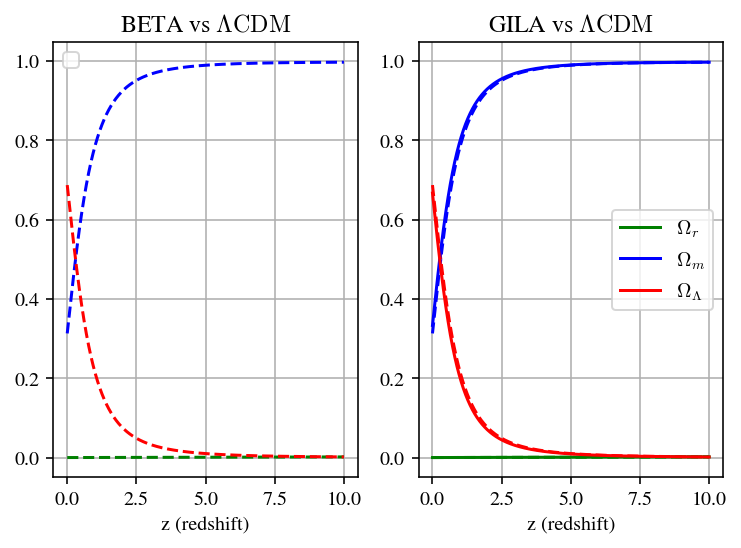

In [6]:
fig, ax = plt.subplots(1, 2)
#fig.suptitle(r'$\rm{\Lambda CDM}$ biased')

ax[0].set_title(r'BETA vs $\rm{\Lambda CDM}$')
ax[0].grid()
ax[0].plot(zs, Omega_r_lcdm_z, 'g--')
ax[0].plot(zs, Omega_m_lcdm_z, 'b--')
ax[0].plot(zs, Omega_Lambda_lcdm_z, 'r--')
#ax[0].plot(zs, Omega_r_beta_B1_z, 'g', label=r'$\Omega_r$')
#ax[0].plot(zs, Omega_m_beta_B1_z, 'b', label=r'$\Omega_m$')
#ax[0].plot(zs, Omega_Lambda_beta_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
ax[0].set_xlabel('z (redshift)')
ax[0].legend()

ax[1].set_title(r'GILA vs $\rm{\Lambda CDM}$')
ax[1].grid()
ax[1].plot(zs, Omega_r_lcdm_z, 'g--')
ax[1].plot(zs, Omega_m_lcdm_z, 'b--')
ax[1].plot(zs, Omega_Lambda_lcdm_z, 'r--')
ax[1].plot(zs, Omega_r_gila_B1_z, 'g', label=r'$\Omega_r$')
ax[1].plot(zs, Omega_m_gila_B1_z, 'b', label=r'$\Omega_m$')
ax[1].plot(zs, Omega_Lambda_gila_B1_z, 'r', label=r'$\Omega_{{\Lambda}}$')
ax[1].set_xlabel('z (redshift)')
ax[1].legend()

os.chdir(path_figures)
fig.savefig('Omegas_LCDM_biased_{}.pdf'.format(L_bar))

No handles with labels found to put in legend.


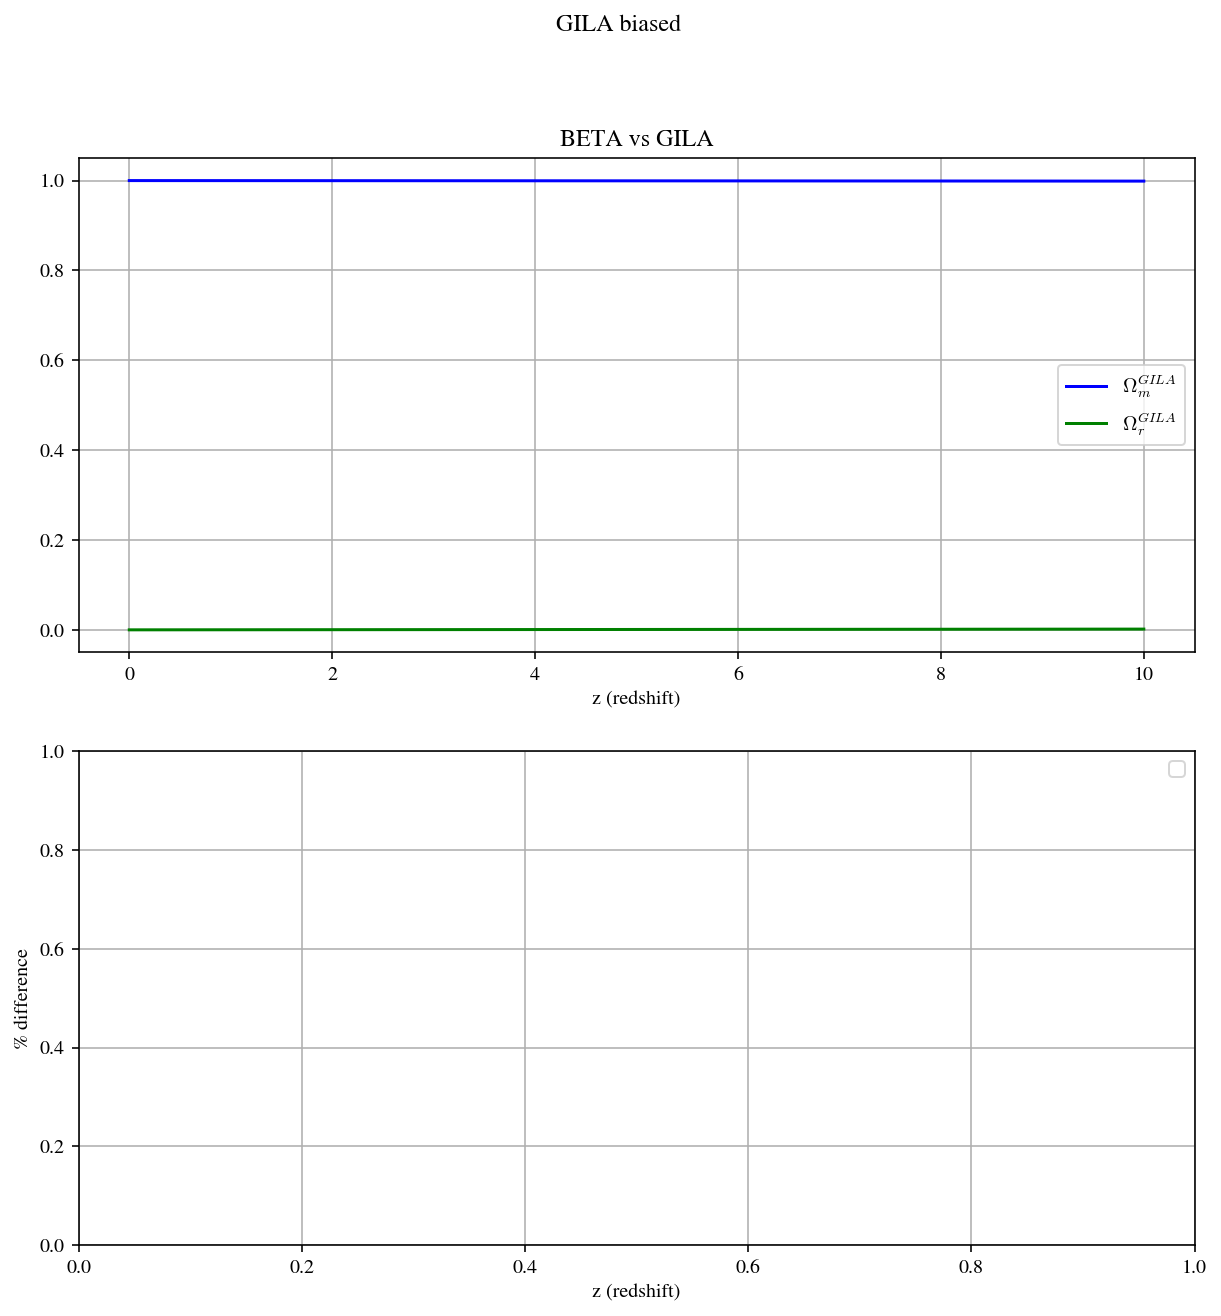

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle(r'GILA biased')
ax[0].set_title(r'BETA vs GILA')
ax[0].grid()
#ax[0].plot(zs, Omega_m_beta_B2_z, '--b', label=r'$\Omega_m^{BETA}$')
#ax[0].plot(zs, Omega_r_beta_B2_z, '--g', label=r'$\Omega_r^{BETA}$')
ax[0].plot(zs, Omega_m_gila_B2_z, 'b', label=r'$\Omega_m^{GILA}$')
ax[0].plot(zs, Omega_r_gila_B2_z, 'g', label=r'$\Omega_r^{GILA}$')
ax[0].set_xlabel('z (redshift)')
ax[0].legend()

ax[1].grid()
#ax[1].plot(zs, 100*(1-Omega_m_gila_B2_z/Omega_m_beta_B2_z), 'b',label=r'$\Omega_m$')
#ax[1].plot(zs, 100*(1-Omega_r_gila_B2_z/Omega_r_beta_B2_z), 'g', label=r'$\Omega_r$')
ax[1].set_ylabel('% difference')
ax[1].set_xlabel('z (redshift)')
ax[1].legend()

os.chdir(path_figures)
fig.savefig('Omegas_GILA_biased_{}.pdf'.format(L_bar))


El tema es el siguiente

$\Omega_m^{B2}(z=0) \neq \Omega_{m,0}^{B2} $ ya que si $\beta>0$, entonces $H_0^2 > F(H_0)$. Esto tiene implicancias en las definiciones de Omega_r_gila_B2_z y Omega_m_gila_B2_z

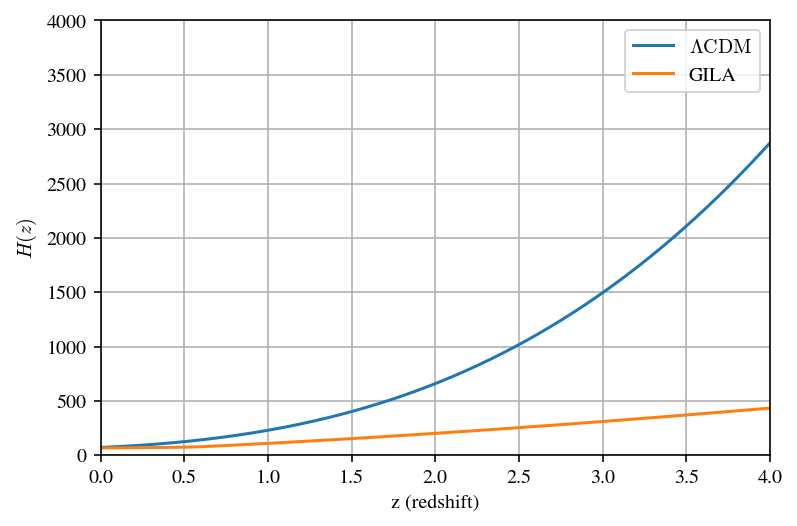

In [8]:
plt.grid()
plt.plot(zs, H_0_lcdm * E_2(zs, Omega_r_lcdm, Omega_m_lcdm, Omega_Lambda_lcdm))
#plt.plot(zs, Hs_beta)
plt.plot(zs, Hs_gila)
#plt.xlim(0,3)
plt.xlabel('z (redshift)')
plt.ylabel(r'$H(z)$')
#plt.legend([r'$\rm{\Lambda CDM}$', r'BETA', r'GILA'])
plt.legend([r'$\rm{\Lambda CDM}$', r'GILA'])
plt.xlim(0, 4)
plt.ylim(0, 4000)
plt.show()
